# Sketchbook for galaxy plotter

Here you will find a quickly written program to handle galaxy data, from download to encode.

You will need to install mw_plot, make sure to load a proper environment and then follow the instr



# Task 1

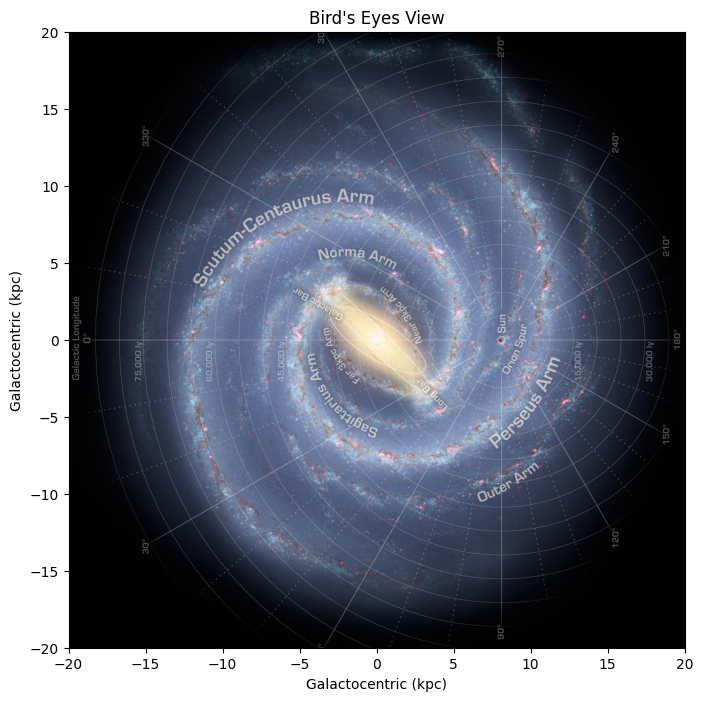

In [1]:
#Task 1: Install the git package and reproduce the image of the milky way via MWSkyMap (see attached code).
import numpy as np
from astropy import units as u
from mw_plot import MWFaceOn

mw1 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)

mw1.title = "Bird's Eyes View"

mw1.scatter(8 * u.kpc, 0 * u.kpc, c="r", s=2)

# Task 2

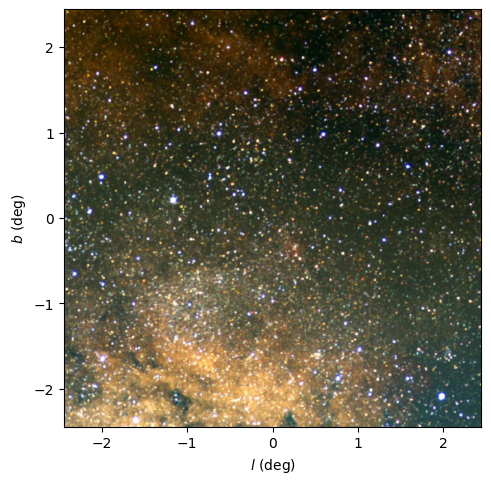

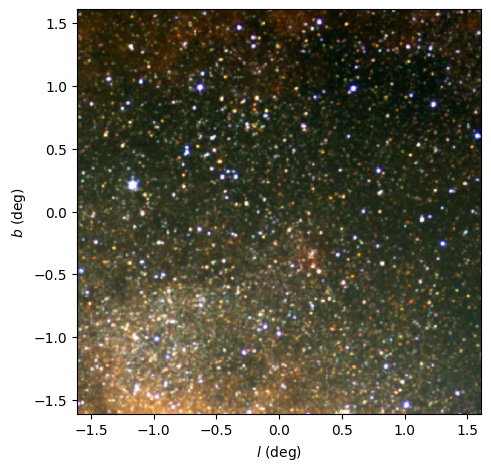

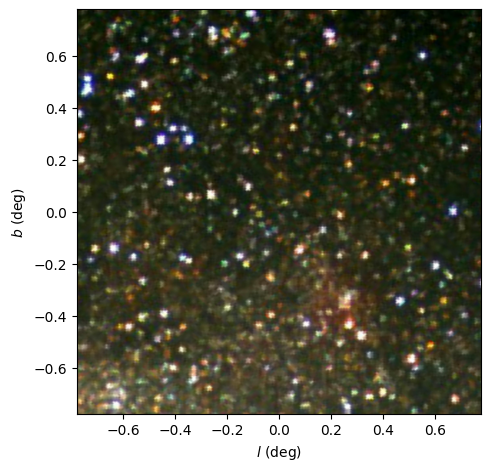

In [2]:
#Task 2: Generate a few (at least three in total) visualizations of the milky way sector starting in different centers (try "M31") and with different radius (be careful on the units!).
import matplotlib.pyplot as plt
from astropy import units as u
from mw_plot import MWSkyMap

mw1 = MWSkyMap(
    #center="M31",
    radius=(8800, 8800) * u.arcsec,
    background="Mellinger color optical survey",
)
fig, ax = plt.subplots(figsize=(5, 5))
mw1.transform(ax)
mw1.savefig('galaxy_large.png')

mw2 = MWSkyMap(
    #center="",
    radius=(5800, 5800) * u.arcsec,
    background="Mellinger color optical survey",
)
fig, ax = plt.subplots(figsize=(5, 5))
mw2.transform(ax)
mw2.savefig('galaxy_medium.png')

mw3 = MWSkyMap(
    #center="",
    radius=(2800, 2800) * u.arcsec,
    background="Mellinger color optical survey",
)
fig, ax = plt.subplots(figsize=(5, 5))
mw3.transform(ax)
mw3.savefig('galaxy_small.png')
plt.show()



We built three visualizations, with each starting in different centers. We then save each of the figures so that we can use them in later tasks.

# Task 3

In this cast we convert the image from task 2 that we chose (galaxy_medium.png) to a numpy array. This numpy array consists of the pixels being constituted as the three colors, red, blue and green. This conversion is done by a function that we made called image_to_rgb_array.

Shape: (500, 500, 3)
Data type: uint8


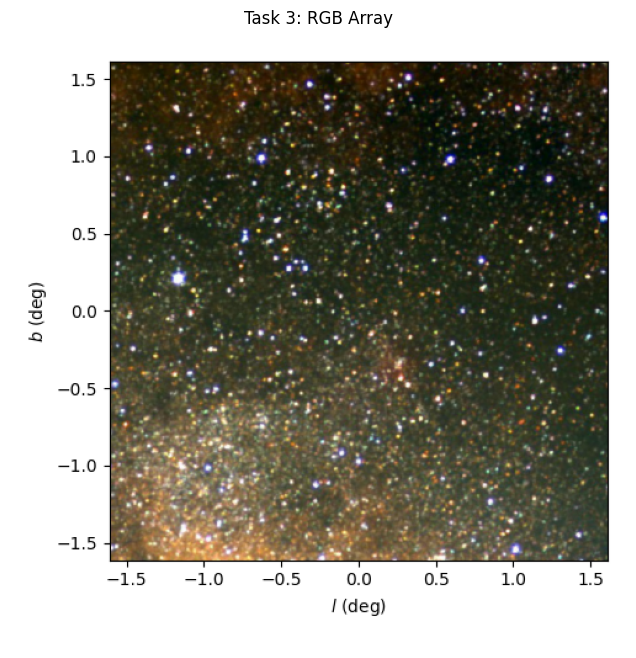

In [20]:
# Task 3: Convert the image generated into a rgb np.array (each pixel will be a list of 3 number, Red, Green, Blue (rbg).
from functions import image_to_rgb_array
import matplotlib.pyplot as plt
from PIL import Image

# Topic 1 Task 3:
def image_to_rgb_array(image_path):
    """
    A function to load an image file and convert it to RGB np.array
    
    Input
    -----
    image_path: str
        Path to the image file
        
    Output
    ------
    np.array(h, w, 3): A 3d map of each pixel in RGB encoding
    """
    img = Image.open(image_path)
    rgb_array = np.array(img)
    
    # If image has alpha channel (RGBA), take only RGB
    if len(rgb_array.shape) == 3 and rgb_array.shape[2] == 4:
        rgb_array = rgb_array[:, :, :3]
    
    return rgb_array

# Use the function
rgb_array = image_to_rgb_array('galaxy_medium.png')
print(f"Shape: {rgb_array.shape}")
print(f"Data type: {rgb_array.dtype}")

# Verify it loaded correctly
plt.figure(figsize=(8, 8))
plt.imshow(rgb_array)
plt.title('Task 3: RGB Array')
plt.axis('off')
plt.show()

# Task 4

Here we want to create an encoding where we manually categorize each pixel to 3 color channels; Red, blue, and green (RGB). Very simple endocing, if red is bigger than blue and green, then the pixel is red-dominant. If blue is bigger than red and green, then blue-dominant etc...

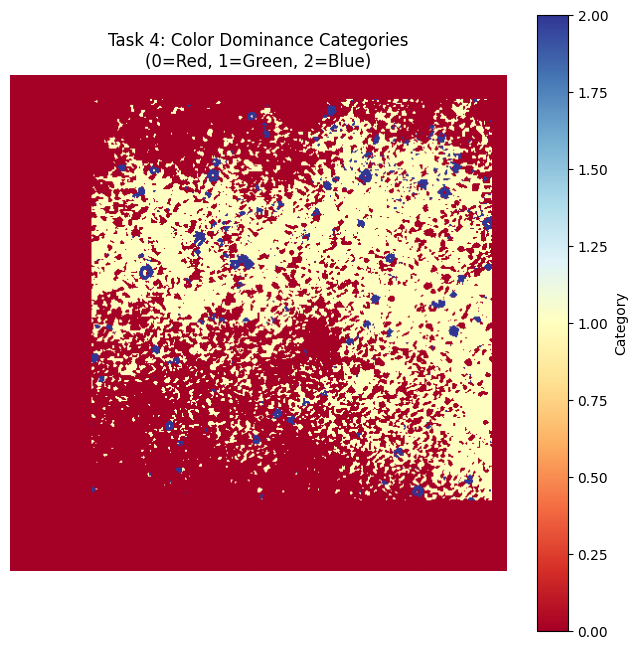

In [25]:
# Task 4
from functions import categorize_pixels

def categorize_pixels(rgb_array):
    """
    Kategoriser piksler som rød, grønn eller blå
    """
    import numpy as np
    h, w, _ = rgb_array.shape
    categories = np.zeros((h, w), dtype=int)
    for i in range(h):
        for j in range(w):
            r, g, b = rgb_array[i, j]
            if r > g and r > b:
                categories[i, j] = 0
            elif g > r and g > b:
                categories[i, j] = 1
            elif b > r and b > g:
                categories[i, j] = 2
    return categories

categories = categorize_pixels(rgb_array)

plt.figure(figsize=(8, 8))
plt.imshow(categories, cmap='RdYlBu')
plt.title('Task 4: Color Dominance Categories\n(0=Red, 1=Green, 2=Blue)')
plt.colorbar(label='Category')
plt.axis('off')
plt.show()

The map looks like this because in the Milky Way there are mostly warmer colors like red, yellow, and orange. There are barely any greens as well, and some stars have a hint of a strong blue in them.

# Task 5

In this task we used K-means clustering. This is a form of an unsupervised machine learning algorithm that groups similar data points by a number of clusters. Relative to this task, the clusters represent the color regions of the map, so the dark regions will clump toger, the brighter regions will clump together etc.. In total there are 6 clusters.

Cluster centers:
[[ 53.14986479  54.33547156  35.77376685]
 [254.21329057 254.16075792 254.08011465]
 [181.86148238 160.03803159 128.9691373 ]
 [ 28.31339339  30.43261952  14.5581387 ]
 [ 86.22692296  80.94731283  59.31168714]
 [129.39087351 111.96388049  83.43100629]]
Unique clusters: [0 1 2 3 4 5]
Cluster distribution: [47896 85119  8165 55273 33334 20213]


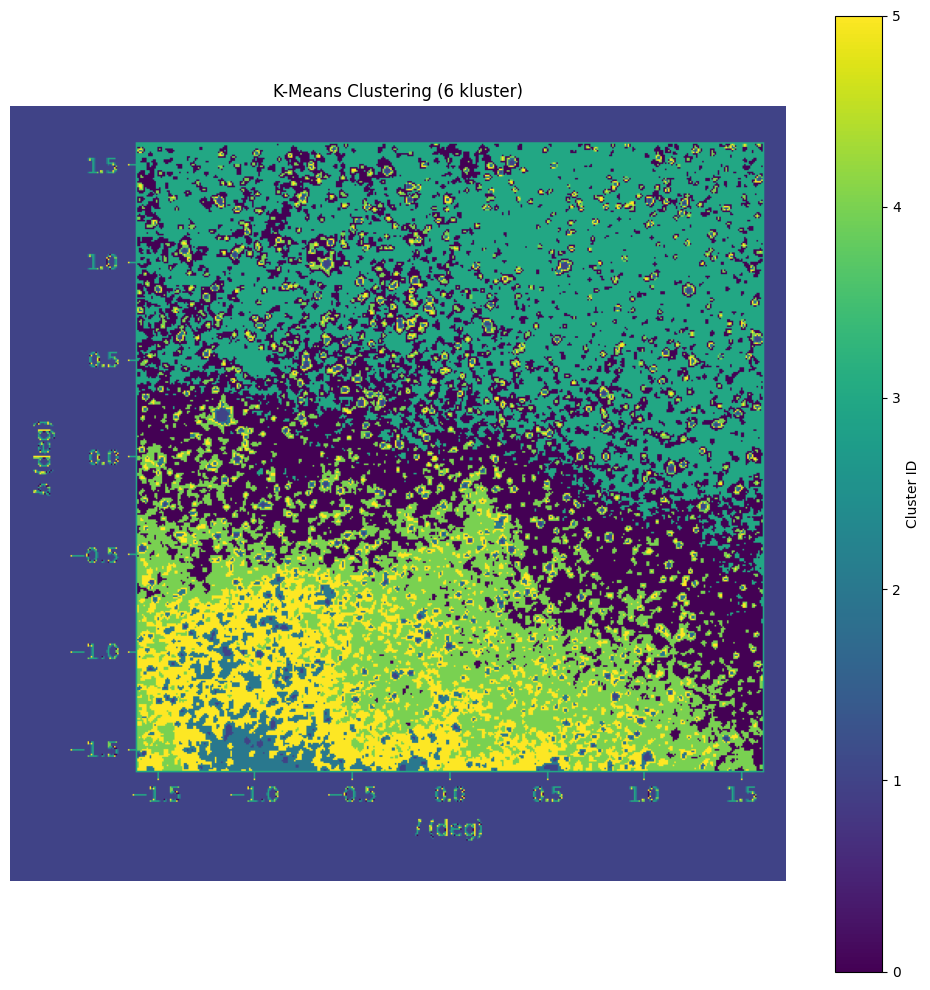

In [22]:
# Task 5: Use K-NN (Nearest neighbor, not discussed in class but extremely simple) or K-means to cluster the data
from functions import apply_kmeans_clustering

def apply_kmeans_clustering(rgb_array, n_clusters=6, visualize=True):
    """
    Apply K-means clustering to an RGB array
    
    Input
    -----
    rgb_array: np.array
        RGB image array (h, w, 3)
    n_clusters: int
        Number of clusters (default: 6)
    visualize: bool
        Whether to show the clustering visualization
        
    Output
    ------
    predicted_image: np.array
        Cluster labels reshaped to image dimensions (h, w)
    kmeans: KMeans object
        Fitted KMeans model
    """
    from sklearn.cluster import KMeans
    import numpy as np
    import matplotlib.pyplot as plt
    
    h, w, _ = rgb_array.shape
    rgb_flat = rgb_array.reshape(-1, 3)
    rgb_flat = rgb_flat.astype(np.float64)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(rgb_flat)
    cluster_labels = kmeans.labels_
    predicted_image = cluster_labels.reshape(h, w)
    
    print(f"Cluster centers:\n{kmeans.cluster_centers_}")
    print(f"Unique clusters: {np.unique(cluster_labels)}")
    print(f"Cluster distribution: {np.bincount(cluster_labels)}")
    
    if visualize:
        plt.figure(figsize=(10, 10))
        plt.imshow(predicted_image, cmap='viridis')
        plt.title(f'K-Means Clustering ({n_clusters} kluster)')
        plt.colorbar(label='Cluster ID')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return predicted_image, kmeans

# Use the function
predicted_image, kmeans = apply_kmeans_clustering(rgb_array, n_clusters=6)

# Task 6

We imposed the cluster to the image back in task 2, specifically we chose the galaxy_medium.png. 

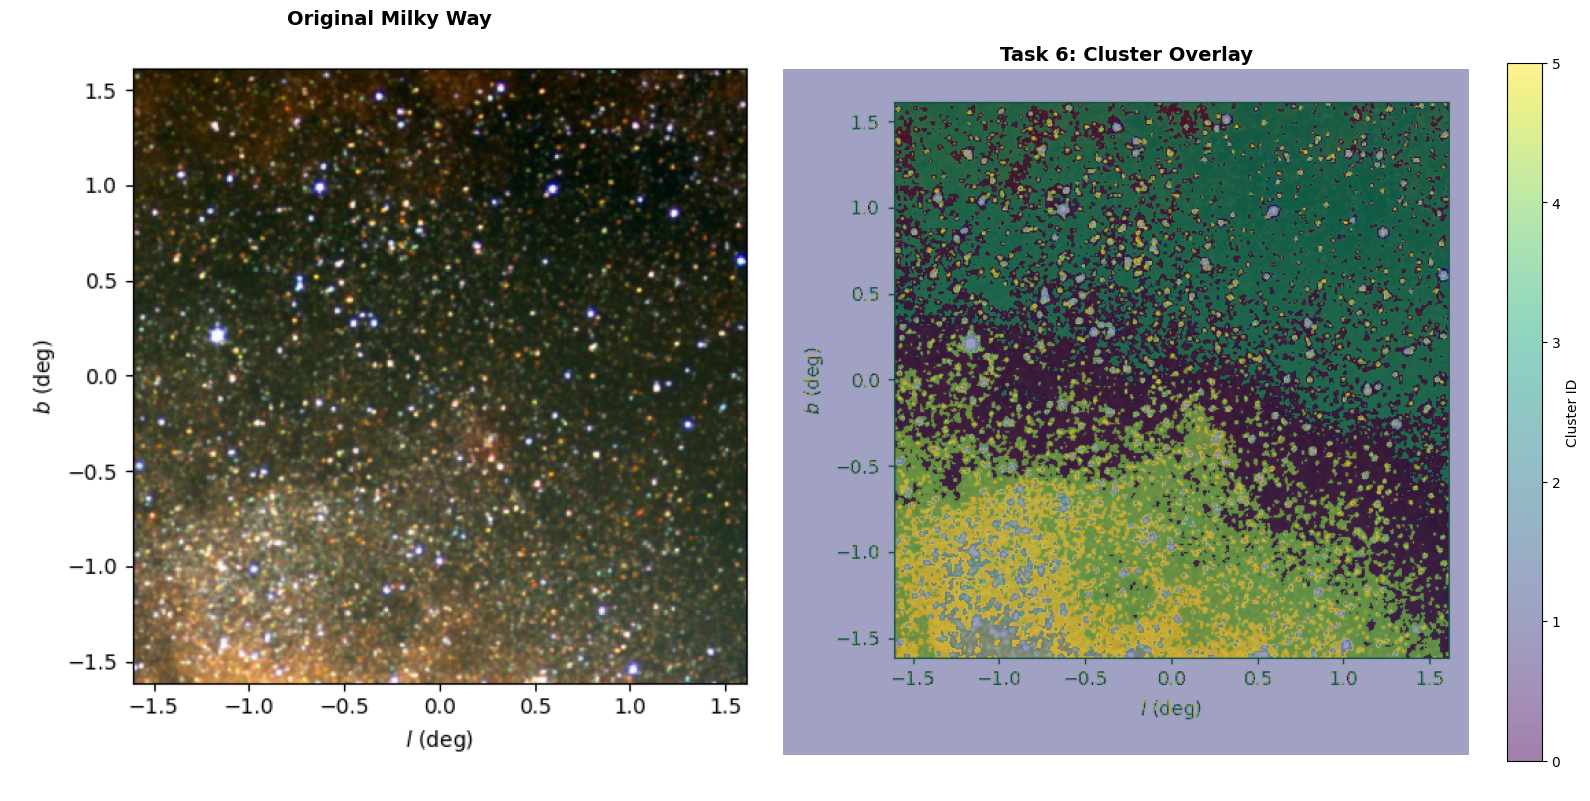

In [21]:
# Task 6: Over-impose your cluster to the image generated in task 2
import matplotlib.pyplot as plt
from functions import image_to_rgb_array


# We reuse the function from task 3 to grab the picture
rgb_array_task6 = image_to_rgb_array('galaxy_medium.png')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Original image
axes[0].imshow(rgb_array_task6)
axes[0].set_title('Original Milky Way', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Overlay
axes[1].imshow(rgb_array_task6)
axes[1].imshow(predicted_image, cmap='viridis', alpha=0.5)
axes[1].set_title('Task 6: Cluster Overlay', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.colorbar(axes[1].images[1], ax=axes[1], label='Cluster ID', fraction=0.046)
plt.tight_layout()
plt.savefig('task6_cluster_overlay.png', dpi=300, bbox_inches='tight')
plt.show()


We show the side by side between the original Milky Way and the one with the clustered overlay, the higher the alpha, the higher the overlay will show. We see a clear distinction between the darker green at the top and the yellowish-green at the bottom. 

# Task 7

In this task we want to try different methods to categorize the pixels. In task 4 we used the colors red, blue and green. This time we will take a different approach, in which we will be using the brightness instead.



Kategori-shape: (500, 500)


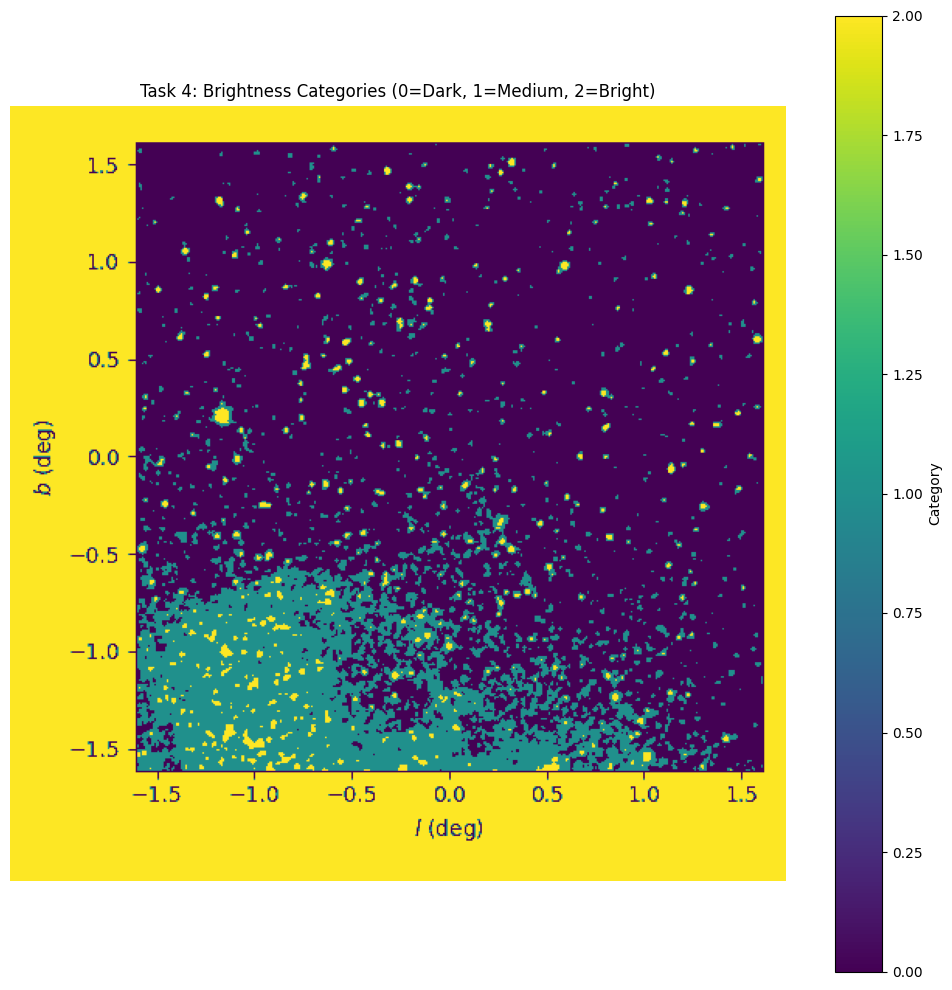

Cluster centers:
[[ 53.14986479  54.33547156  35.77376685]
 [254.21329057 254.16075792 254.08011465]
 [181.86148238 160.03803159 128.9691373 ]
 [ 28.31339339  30.43261952  14.5581387 ]
 [ 86.22692296  80.94731283  59.31168714]
 [129.39087351 111.96388049  83.43100629]]
Unique clusters: [0 1 2 3 4 5]
Cluster distribution: [47896 85119  8165 55273 33334 20213]


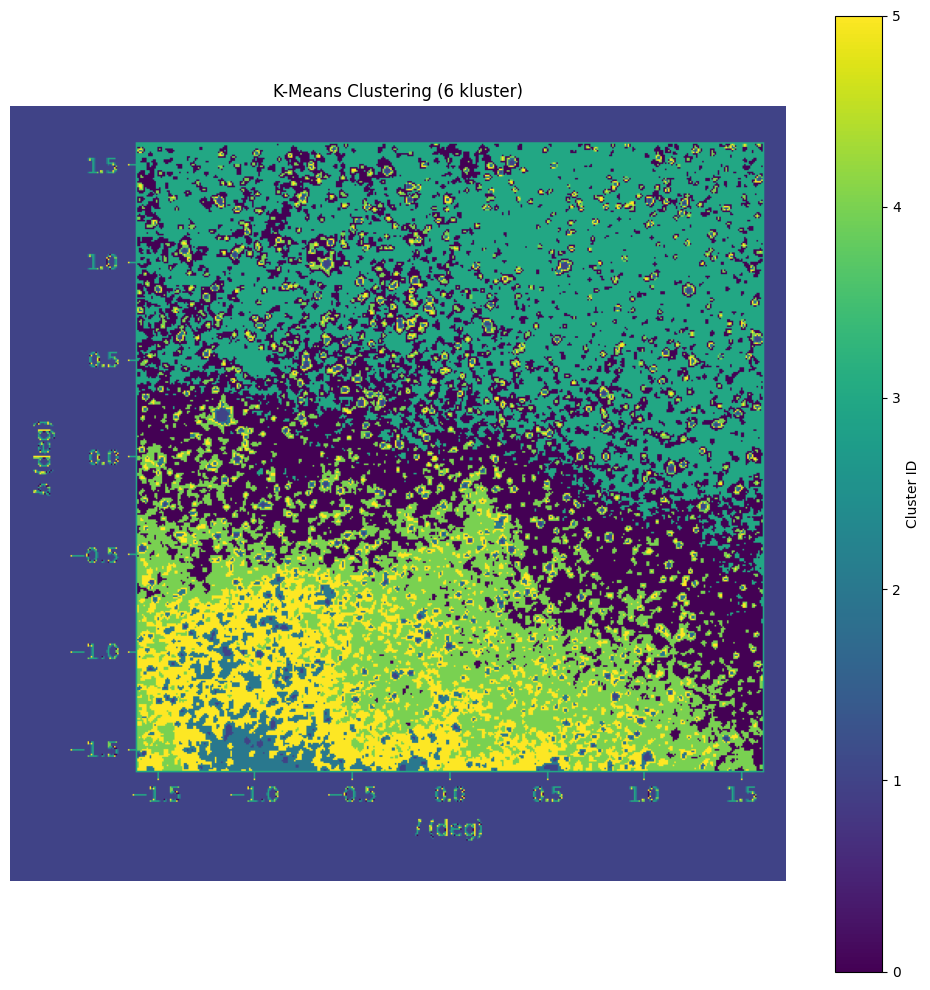

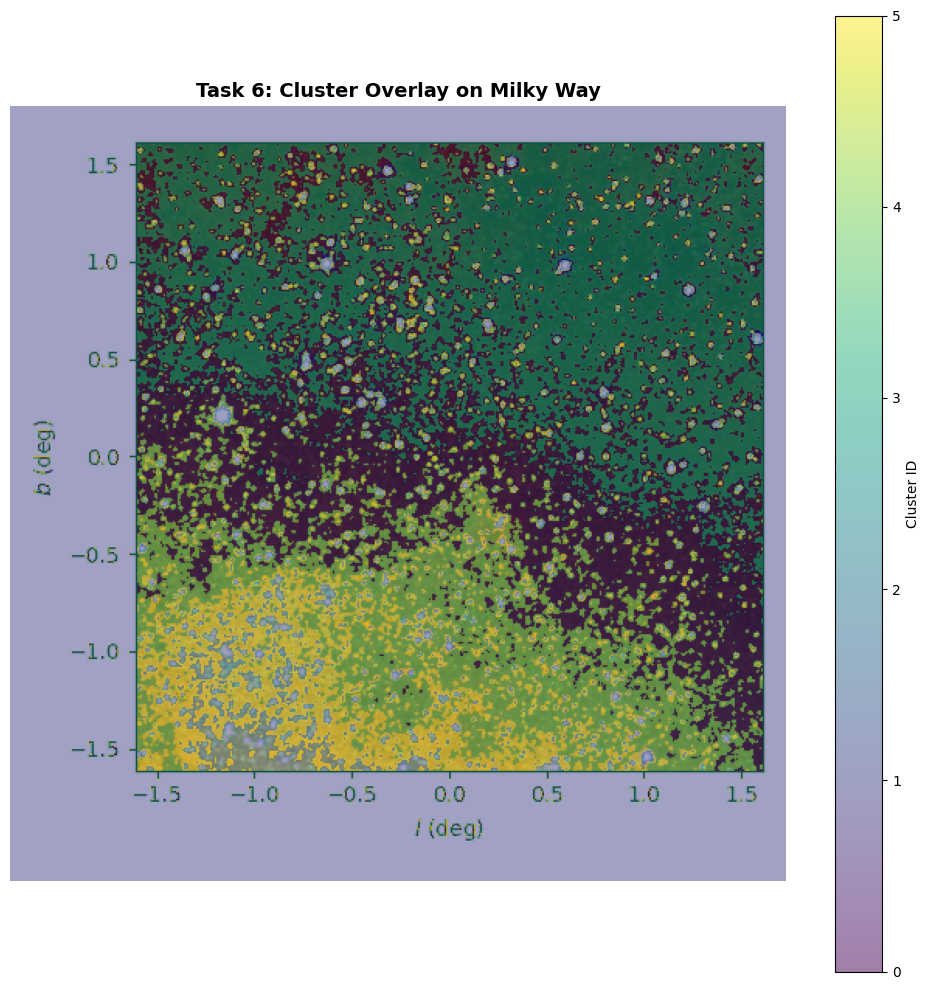

In [28]:
# Task 7: Try different categories (task 4), repeating tasks 5 and 6
import matplotlib.pyplot as plt
import numpy as np
from functions import apply_kmeans_clustering, image_to_rgb_array

# Load image with function from task 3
rgb_array = image_to_rgb_array('galaxy_medium.png')

# Task 4 but based on brightness
def categorize_pixels_brightness(rgb_array):
    """
    Categorizes pixels based on brightness
    """
    h, w, _ = rgb_array.shape
    categories = np.zeros((h, w), dtype=int)
    brightness = rgb_array.mean(axis=2)
    
    for i in range(h):
        for j in range(w):
            if brightness[i, j] < 85:
                categories[i, j] = 0  # Mørk
            elif brightness[i, j] < 170:
                categories[i, j] = 1  # Medium
            else:
                categories[i, j] = 2  # Lys
    return categories

categories = categorize_pixels_brightness(rgb_array)
print(f"Kategori-shape: {categories.shape}")

# Visualize the categories
plt.figure(figsize=(10, 10))
plt.imshow(categories, cmap='viridis')
plt.title('Task 4: Brightness Categories (0=Dark, 1=Medium, 2=Bright)')
plt.colorbar(label='Category')
plt.axis('off')
plt.tight_layout()
plt.show()

# We use the function from task 5
predicted_image, kmeans = apply_kmeans_clustering(rgb_array, n_clusters=6, visualize=True)

# Task 6: Over-impose cluster to the image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_array)
plt.imshow(predicted_image, cmap='viridis', alpha=0.5)
plt.title('Task 6: Cluster Overlay on Milky Way', fontsize=14, fontweight='bold')
plt.colorbar(label='Cluster ID')
plt.axis('off')
plt.tight_layout()
plt.savefig('task7_cluster_overlay.png', dpi=300, bbox_inches='tight')
plt.show()



In the first image it is a visualization of task 4 where we now based it on brightness. By comparing it to the first encoding where we based it on colors, this one in task 7 seems much better. The previous had too much red and felt like it wasn't representative of the mat itself. Meanwhile the one based on brightness feels better.

Between our task 4 encoding versus the K-means cluster method, we can see much more differences. K-means found much more patterns that we didn't program, for example in task 4 brightness method (between -0.5 and 0.0), that is the only bright spot apparently, but in the K-means, it automatically identified the dark space, and galactic center.

# Topic 1 Conclusion

To summarize the topic, first we had to install a python library where we could then reproduce an image of the Milky Way Galaxy. We then created some visualizations. After the visualizations, we encoded some methods to that we could segment each region og the milky way, so that we could see some recognizable patterns. 

We encoded a manual method where we first based the milky way of the three colors red, blue, and green. We found quickly out that it was a bad method as the result was simply not detailed. After that we used the K-means clustering where we had much more success. It groups similar pixels into clusters. This method recognized immidiately the characteristics of the milky way, such as bright center, and the dark space.

We conclude that unsupervised machine learning can be much more effective in identifying patterns and segment structures of the galaxy, instead of human rules. 

# Self-reflections

Rahul: For my part, I found the project very interesting and meaningful. It was very cool to see how something that has been studied for so many years can be visualized with unsupervised machine learning-methods. The difference between automatic and manual computing was massive, and there were a lot of things that we could take away from that. The tasks were on a decent level as in some places we needed help and others we breezed past them. 

**References**

<a id="ref1"></a>[1] Aksel Hiorth. *Computational Engineering and Modeling*. https://github.com/ahiorth/CompEngineering, 2021.

<a id="ref2"></a>[2] Ringnes, Truls; Hammerstrøm, Maria: Melkeveien i Store norske leksikon på snl.no. Hentet 4. desember 2025 fra https://snl.no/Melkeveien.
